In [1]:
# The date after which we'll summarize data (up to today)
date = "2019-01-18"

In [2]:
from IPython.display import display, HTML
HTML("<h2>Report summary for {}</h2>".format(date))

This is a summary of activity in the JupyterHub repositories over the last 30 days.
It should not be treated as set of statistics to optimize, but should instead be
used to find opportunities to pursue ways that we can recognize and congratulate the
work that folks are doing in the community. It should be a birds-eye view of what's
going on that inspires people to dig a bit deeper.

In [2]:
from glob import glob
import os.path as op
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 300

csv_files = glob('../../reports/{}/data/*.csv'.format(date))

In [3]:
data = []
for ifile in csv_files:
    name = op.basename(ifile)
    org, repo = name.rsplit('-', 1)[0].split('_', 1)
    idata = pd.read_csv(ifile)
    idata['org'] = org
    idata['repo'] = repo
    idata = idata.rename(columns={'commits': 'count', 'comments': 'count'})
    kind = 'commits' if 'committers' in ifile else 'comments'
    idata['kind'] = kind
    data.append(idata)

data = pd.concat(data, sort=False).reset_index(drop=True)

data_total = data.groupby(['user', 'kind'])['count'].sum().reset_index()

ValueError: No objects to concatenate

In [5]:
teams = pd.read_csv('../../data/teams.csv')

def assign_team(val):
    if val in teams['username'].values:
        team = teams.query('username == @val')['team'].iloc[-1] 
    else:
        team = "NONE"
    return team
data['association'] = data['user'].map(assign_team)

## Total commits and comments by repository

/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


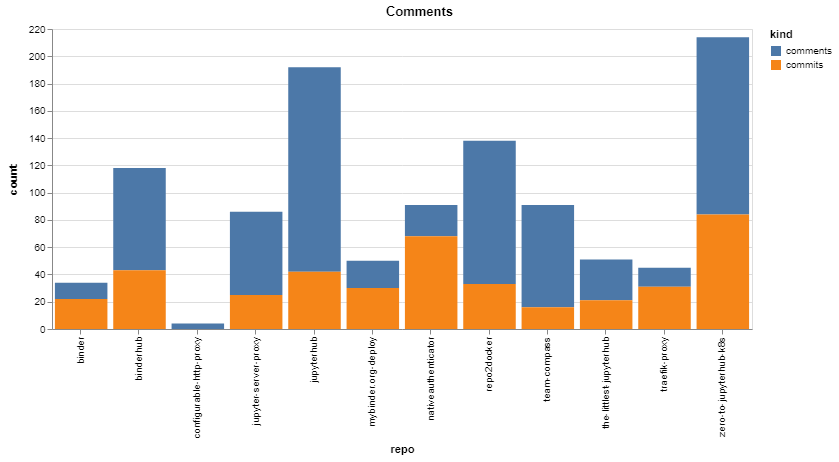

In [6]:
pltdata = data.groupby(['org', 'repo', 'kind'])['count'].sum().reset_index()
comments = alt.Chart(pltdata, title="Comments", width=700).mark_bar().encode(
    x='repo',
    y='count',
    color='kind'
)
comments

## Total commits and comments by user

In [7]:
# Define the color scale we'll use to categorize people
color_scale = alt.Scale(
    domain=["red", "lead","blue", "jupyterhub", "NONE"],
    range=["#fdbaba", "#fdbaba", "#bac5fd", "#ffbb74", "green"]
)

pltdata = data.groupby(['user', 'association', 'kind'])['count'].sum().reset_index()
pltcommits = pltdata.query('kind == "commits"')
pltcomments = pltdata.query('kind == "comments"')

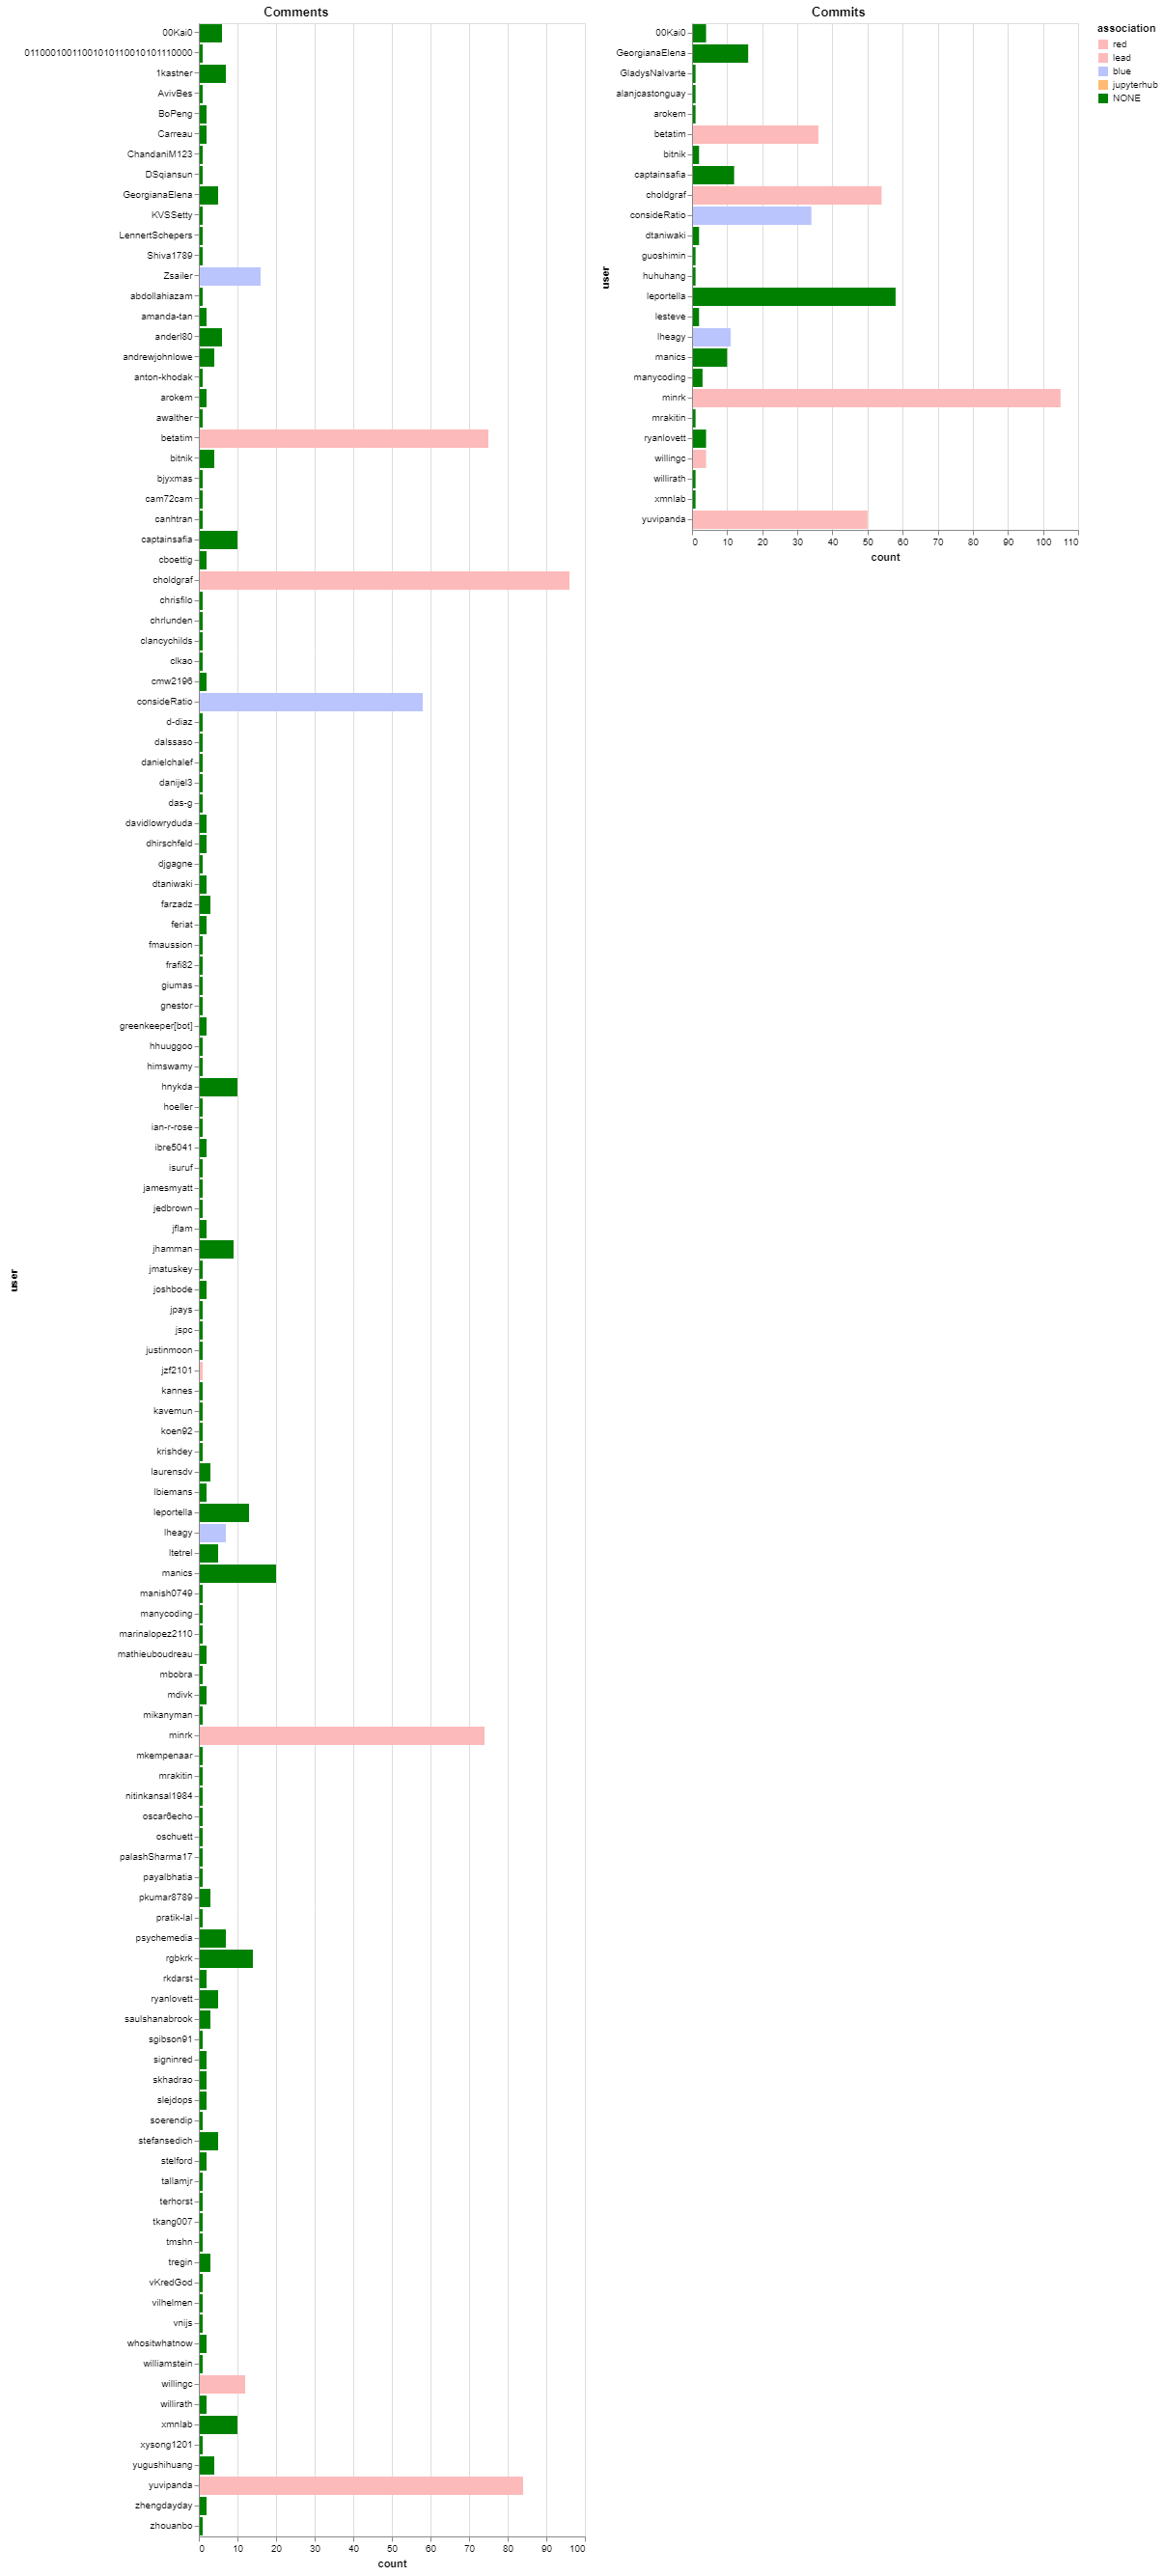

In [8]:
commits = alt.Chart(pltcommits, title="Commits").mark_bar().encode(
    x='count',
    y='user',
    color=alt.Color('association', scale=color_scale)
)

comments = alt.Chart(pltcomments, title="Comments").mark_bar().encode(
    x='count',
    y='user',
    color=alt.Color('association', scale=color_scale)
)

comments | commits

## Percentage commits and comments by user type

In [9]:
def to_percentage(data):
    data = data / data.sum()
    data.name = 'percent'
    return data * 100

totalcommits = to_percentage(pltcommits.groupby('association')['count'].sum()).reset_index()
totalcommits['kind'] = "commits"
totalcomments = to_percentage(pltcomments.groupby('association')['count'].sum()).reset_index()
totalcomments['kind'] = "comments"
totalboth = pd.concat([totalcomments, totalcommits])

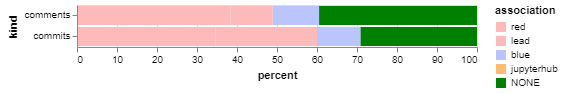

In [10]:
alt.Chart(totalboth).mark_bar().encode(
    x='percent',
    y='kind',
    color=alt.Color('association', scale=color_scale)
)